In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
from IPython.core.display import display, HTML
from IPython.display import clear_output
import matplotlib.image as mpimg
import numpy as np

In [3]:
initials = np.load('images/initials.npy')
len(initials)

1000

Red - player \
Green - forest \
Blue - stones 

Moves: left, right, up, down

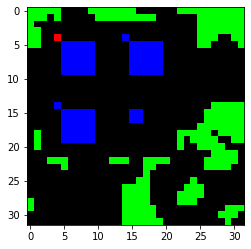

In [4]:
initial = initials[456]
plt.imshow(np.moveaxis(initial, (0, 1, 2), (2, 1, 0)) * 255);

# Environment

In [8]:
class Raic2020Python:
    def __init__(self, state, centr=True, game_length=200):
        self.initial_state = state.copy()
        self.state = None
        self.unit = None
        #self.actions = [(-1, -1, -1), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1), (1, -1, 0), (1, 1, 0), (1, 0, -1), (1, 0, 1)]
        self.actions = [(0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]
        self.tick = None
        self.done = None
        self.game_length = game_length
        self.centr = centr
        
    def reset(self):
        self.state = self.initial_state.copy()
        i = self.state[0].argmax()
        self.unit = i // 32, i % 32
        self.tick = 0
        self.done = False
        if self.centr:
            return self.centralize(self.state)
        else:
            return self.centralize(self.state)
    
    def step(self, i):
        kind, dx, dy = self.actions[i]
        x, y = self.unit
        reward = 0
        if x + dx < 0 or x + dx >= 32 or y + dy < 0 or y + dy >= 32:
            kind = -1
            
        if kind == 0 and self.state[:, x + dx, y + dy].max() == 0:
            self.state[0, x + dx, y + dy] = 1
            self.state[0, x, y] = 0
            self.unit = x + dx, y + dy
        elif kind == 0 and self.state[1, x + dx, y + dy] == 1:
            self.state[1, x + dx, y + dy] = 0
            reward = 1
            
        self.tick += 1
        self.done = self.tick == self.game_length
        if self.centr:
            return self.centralize(self.state.copy()), reward, self.done, {}
        else:
            return self.state.copy(), reward, self.done, {}
    
    
    def centralize(self, state):
        mask = np.zeros((3, 32, 32), dtype=np.uint8)
        mask[2, :, :] = 1
        x, y = self.unit
        dx = 15 - x
        dy = 15 - y
        mask[:, max(dx, 0):min(32+dx, 32), max(dy, 0):min(32+dy, 32)] = state[:, max(-dx, 0):min(32-dx, 32), max(-dy, 0):min(32-dy, 32)]

        return mask

# REINFORCE

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    
    with torch.no_grad():
        output = model(torch.tensor(states).to(torch.float))
    output = output.detach().numpy()
    
    return np.exp(output)

In [16]:
#def image(state, axis=2):
#    layer = state['map'][:32, :32, 0]
#    return np.stack((layer == 3,layer == 8,(layer != 3)*(layer != 0)*(layer != 8)), axis=axis).astype(int)

In [17]:
def generate_session(env, t_max=500, tempr=2):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]
        action_probs_copy = action_probs.copy()
        action_probs = action_probs ** tempr
        action_probs = action_probs / sum(action_probs)
        
        # Sample action with given probabilities.
        
        a = np.random.choice(range(len(action_probs)), p=action_probs)
        new_s, r, done, info = env.step(a)
        
        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [19]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    G = []
    for r in reversed(rewards):
        if not G:
            G.append(r)
        else:
            G.append(r + gamma * G[-1])
    
    return G[::-1]

In [20]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [21]:
def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-1):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, len(env.actions)), dim=1)
   
    # Compute loss here. Don't forget entropy regularization with `entropy_coef` 
    entropy = -entropy_coef * (probs * log_probs).sum()
    
    
    loss = torch.mean(log_probs_for_actions * cumulative_returns) + entropy
    #loss = -entropy
    
    # Gradient descent step
    optimizer.zero_grad()
    (-loss).backward()
    optimizer.step()

    # technical: return session rewards to print them later
    return np.sum(rewards)

In [22]:
def create_gif(states):
    images = []
    for progress, state in enumerate(states):
        im = state.transpose().astype(np.uint8) * 255
        bar = np.zeros((1, 32, 3), dtype=np.uint8)
        bar[:, :int((progress+1) / len(states) * 32), :] = 255
        im = np.concatenate((im, bar), axis=0)
        im = np.repeat(np.repeat(im, 10, axis=0), 10, axis=1)
        #im = im[::-1, :, :]
        #mask = (255 - im.max(axis=2))
        #im = np.stack((mask, mask, mask), 2) + im
        images.append(im)
    imageio.mimsave('images/gif.gif', images, 'GIF', fps=30)   

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x 

In [24]:
GAMMA = 0.95
LEARNING_RATE = 1e-3
ENTROPY_COEF = 1e-3
TEMPERATURE = 1.3

In [25]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for i in range(1000):

    rewards = []
    for _ in range(20):
        initial_picture = initials[np.random.randint(1000)]
        env = Raic2020Python(initial_picture, centr=True, game_length=500)
        states, actions, rewards = generate_session(env, t_max=500, tempr=TEMPERATURE)
        reward = train_on_session(states, actions, rewards, gamma=GAMMA, entropy_coef=ENTROPY_COEF)
        rewards.append(reward)

    create_gif(states)
    clear_output()
    print (f'session={i}')
    print (f'reward={np.mean(rewards)}')
    display(HTML('<img src="images/gif.gif" width="300" align="center">'))    

session=8
reward=0.39520958083832336
